# NLM3 TASK 1: TIME SERIES MODELING

Rancel Hernandez

Feb 6, 2025

### Introduction  
Hospital readmissions can lead to financial penalties from the Centers for Medicare & Medicaid Services (CMS). In this analysis, we examine the daily revenue of a hospital over its first two years of operation to identify trends, seasonality, and potential impacts of CMS fines on revenue fluctuations.  

Using a time series analysis, the aim is to answer the following research question:  
**"What patterns exist in hospital revenue, and how accurately can an autoregressive integrated moving average (ARIMA) model forecast the hospital revenue?"** 

Goals:  
- Explore and visualize revenue trends over time 
- Check for stationarity and perform necessary transformations  
- Analyze seasonality, trends, and autocorrelations
- Develop an ARIMA model to forecast future revenue 

This analysis will provide insights into hospital revenue trends and develop a time series model to forecast future revenue patterns.

## Imports

In [1]:
# load the CSV file into a DataFrame
# data manipulation
import pandas as pd

# misc. numpy functions
import numpy as np

# to plot the visualizations
import matplotlib.pyplot as plt

# test for stationary
from statsmodels.tsa.stattools import adfuller

# spectral density analysis
from scipy.signal import welch

# time series decomposition
from statsmodels.tsa.seasonal import STL

# select ar and ma params
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# forecasting and predictions
from statsmodels.graphics.tsaplots import plot_predict

# implement the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# the error metric used to evaluate the models
from sklearn.metrics import mean_squared_error

## Load, Explore, and Prepare the Data
- Load the CSV file into the DataFrame
- Explore the data
- Check if there are missing values
- Convert integer-based 'Day' index to a datetime index
- Check for duplicates
- Split the data in the train and test sets

In [2]:
# 'medical_time_series 'space' .csv' there is a space in the file name
# the space was removed 
file_path = '/Users/rancelhernandez/Downloads/fj30d8sm59fc83ed9xsi/medical_time_series.csv'

# set the Day col as the index
medical_time_series = pd.read_csv(file_path, index_col='Day')

In [3]:
# print the df to explore the data
medical_time_series.head()

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888


In [4]:
medical_time_series.shape

(731, 1)

In [5]:
# check if there are any missing revenue values
medical_time_series.isna().sum()

Revenue    0
dtype: int64

In [6]:
# check for missing days
missing_days = set(range(1, 732)) - set(medical_time_series.index)
print(f"Missing days in the dataset: {sorted(missing_days)}")

Missing days in the dataset: []


In [7]:
# convert integer-based 'Day' index to a datetime index
# this does not alter the analysis but improves date indexing 
# for certain time series tests and visualizations
medical_time_series.index = pd.date_range(start='2000-01-01', periods=len(medical_time_series), freq='D')

medical_time_series.head()

,Revenue
2000-01-01,0.000000
2000-01-02,-0.292356
2000-01-03,-0.327772
2000-01-04,-0.339987
2000-01-05,-0.124888


In [8]:
# # check if there are any duplicated values
# if the condition is True, then there are zero duplicated dates
medical_time_series.index.duplicated().sum() == 0

True

In [9]:
# define the split point of 80% trainand and 20% test
train_size = int(len(medical_time_series) * 0.8)

# split into train/test sets while maintaining the order
train, test = medical_time_series[:train_size], medical_time_series[train_size:]

In [10]:
print("train:", train.shape, "\ntest:", test.shape)

train: (584, 1) 
test: (147, 1)


## Plot and Evaluate the Time Series
- Visualize the rolling mean and standard deviation
- Assess stationarity using the Augmented Dickey-Fuller (ADF) test
- Analyze frequency components with a Spectral Density plot
- Identify trends and seasonality using Seasonal-Trend decomposition (STL)
- Confirm no trends in the residuals of the decomposed series

In [11]:
# calculate the rolling mean/std to include in the plot
rolling_mean = medical_time_series.rolling(window=24).mean()
rolling_std = medical_time_series.rolling(window=24).std()

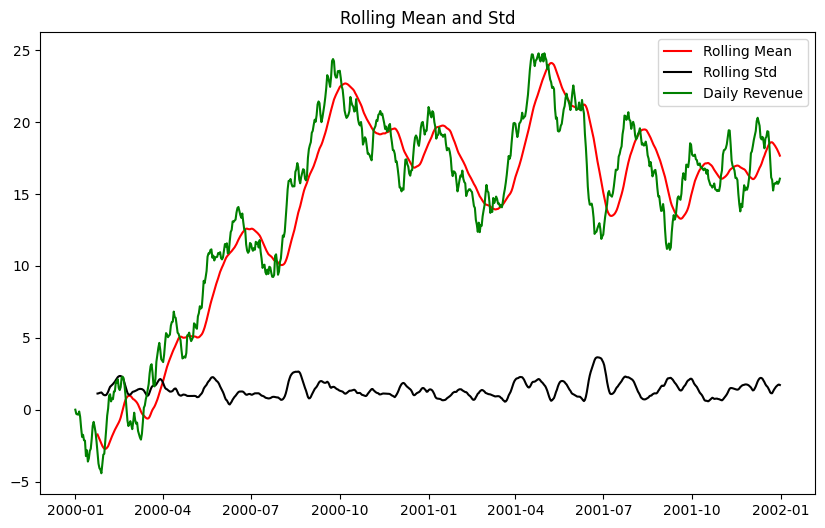

In [12]:
plt.figure(figsize=(10, 6))

# plot the rolling mean, rolling std, and the revenue
plt.plot(medical_time_series.index, np.array(rolling_mean), color='red', label='Rolling Mean')
plt.plot(medical_time_series.index, np.array(rolling_std), color='black', label='Rolling Std')
plt.plot(medical_time_series.index, 
         medical_time_series['Revenue'], 
         label='Daily Revenue',
         color='green'
        )

# add the title and legend
plt.title("Rolling Mean and Std")
plt.legend(loc='best')
plt.show()

In [13]:
# ADF test on the 'Revenue' col
result = adfuller(medical_time_series['Revenue'])

# therefore, ADF statistic is not low enough to reject non-stationarity.
print(F"The ADF statistc is {round(result[0], 2)} > {round(result[4]['5%'], 2)} (5%)")

# the p-value ~0.2 > 0.05 so fail to reject the null hypothesis 
# that the time-series is non-stationary
print("The p-value:", round(result[1], 2))
print("The lags used:", round(result[2], 2))
print("The number of observations used:", round(result[3], 2))

# round the critical values
rounded_critical_values = {key: round(value, 2) for key, value in result[4].items()}
print("Critical Values:", rounded_critical_values)

The ADF statistc is -2.22 > -2.87 (5%)
The p-value: 0.2
The lags used: 1
The number of observations used: 729
Critical Values: {'1%': -3.44, '5%': -2.87, '10%': -2.57}


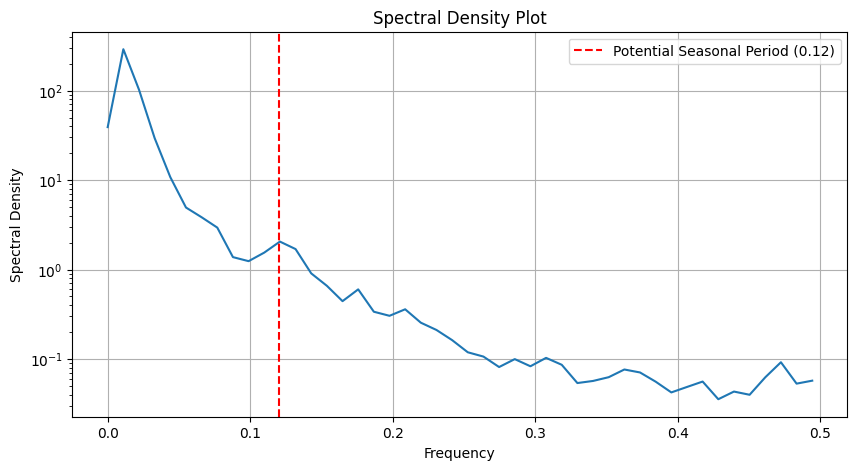

In [14]:
# compute power spectral density using Welch’s method
# adjust the 'nperseg' based on the data
frequencies, power = welch(medical_time_series['Revenue'], nperseg=len(medical_time_series['Revenue'])//8)  

# plot the spectral density
plt.figure(figsize=(10, 5))

# use the log scale for better a visualization
plt.semilogy(frequencies, power)  

# plot the potential seasonal period
plt.axvline(0.12, color='red', linestyle='--', label=f'Potential Seasonal Period (0.12)')


# add the labels and show the grid
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Spectral Density Plot')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# convert the frequency to the time step (days)
# formula 1 / frequency
days = 1 / 0.12
print("The frequency 0.12 equals", round(days), "days.")

The frequency 0.12 equals 8 days.


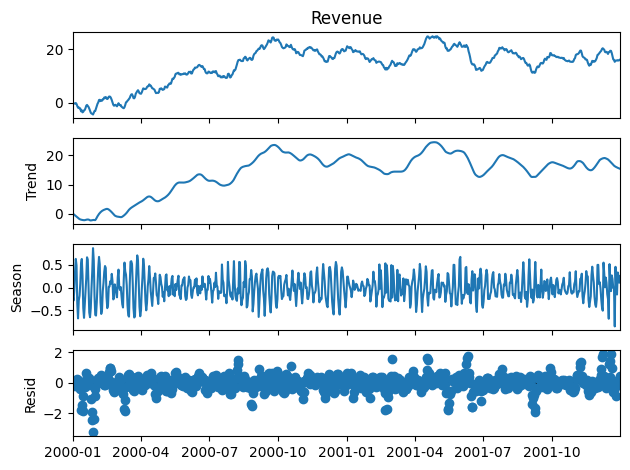

In [16]:
# declare and fit the stl
stl = STL(medical_time_series['Revenue'], robust=True, period=8)  
result = stl.fit()

result.plot()
plt.show()

In [17]:
# get the residuals from the model
residuals = result.resid

# conduct the ADF test on the residuals
result = adfuller(residuals)

# the ADF statistic is significantly lower than the 5% critical value,
# indicating that the residuals are stationary.
print(F"The ADF statistc is {round(result[0], 2)} > {round(result[4]['5%'], 2)} (5%)")

# the p-value 0.0 < 0.05 then we reject the 
# null hypothesis residuals are non-stationary
print("The p-value:", round(result[1], 2))
print("The lags used:", round(result[2], 2))
print("The number of observations used:", round(result[3], 2))

# round the critical values
rounded_critical_values = {key: round(value, 2) for key, value in result[4].items()}
print("Critical Values:", rounded_critical_values)

The ADF statistc is -11.47 > -2.87 (5%)
The p-value: 0.0
The lags used: 6
The number of observations used: 724
Critical Values: {'1%': -3.44, '5%': -2.87, '10%': -2.57}


## Select the Optimal Model
- Plot the Autocorrelation Function 
- Plot the Partial Autocorrelation Function
- Perform the ADF test on the 'Revenue' column with 1 differencing step
- Compare the models of different orders

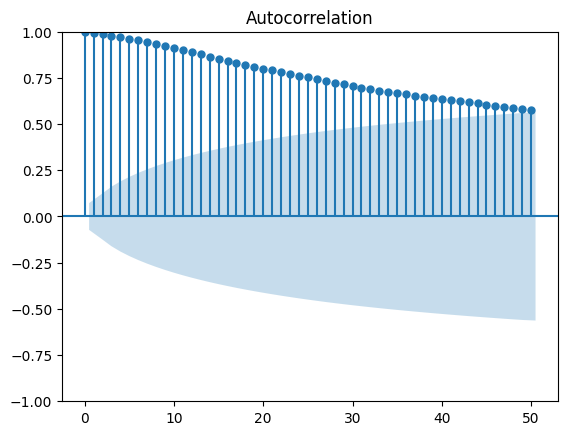

In [18]:
# Autocorrelation Function
plot_acf(medical_time_series['Revenue'], lags=50)
plt.show()

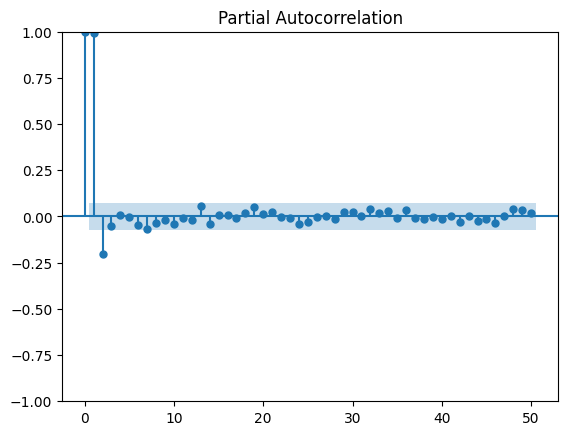

In [19]:
# Partial Autocorrelation Function
plot_pacf(medical_time_series['Revenue'], lags=50)
plt.show()

In [20]:
# perform the ADF test on 'Revenue' with 1 differencing
result = adfuller(medical_time_series['Revenue'].diff().dropna())

# therefore, ADF statistic is low enough to reject non-stationarity.
print(F"The ADF statistc is {round(result[0], 2)} > {round(result[4]['5%'], 2)} (5%)")

# the p-value 0.0 < 0.05 so reject the null hypothesis 
# that the time-series is non-stationary
print("The p-value:", round(result[1], 2))
print("The lags used:", round(result[2], 2))
print("The number of observations used:", round(result[3], 2))

# round the critical values
rounded_critical_values = {key: round(value, 2) for key, value in result[4].items()}
print("Critical Values:", rounded_critical_values)

The ADF statistc is -17.37 > -2.87 (5%)
The p-value: 0.0
The lags used: 0
The number of observations used: 729
Critical Values: {'1%': -3.44, '5%': -2.87, '10%': -2.57}


In [21]:
# define ARIMA model orders to compare performance
model_orders = [(2, 1, 0), (1, 1, 0), (1, 1, 1), (1, 0, 0)]

# dictionary to store model parameters, AIC, BIC, and p-values
models = {}

# at each iteration, fit ARIMA models for each order and store results
for order in model_orders:
    
    model = ARIMA(train, order=order)
    results = model.fit()

    models[order] = {'params': results.params, 
                     'aic': results.aic,
                     'bic': results.bic,
                     'p-vals': results.pvalues
                    }

# print model evaluation metrics
for order, metrics in models.items():
    print("\nOrder:", order)
    print("AIC:", round(metrics['aic'], 4))
    print("BIC:", round(metrics['bic'], 4))
    print(f"P-values:\n{round(metrics['p-vals'], 4)}\n")


Order: (2, 1, 0)
AIC: 706.9183
BIC: 720.0228
P-values:
ar.L1     0.0000
ar.L2     0.4335
sigma2    0.0000
dtype: float64


Order: (1, 1, 0)
AIC: 705.6247
BIC: 714.3611
P-values:
ar.L1     0.0
sigma2    0.0
dtype: float64


Order: (1, 1, 1)
AIC: 707.1357
BIC: 720.2402
P-values:
ar.L1     0.0000
ma.L1     0.5866
sigma2    0.0000
dtype: float64


Order: (1, 0, 0)
AIC: 822.2383
BIC: 835.348
P-values:
const     0.1064
ar.L1     0.0000
sigma2    0.0000
dtype: float64



## Train the Model, Forecast, and Print the Summary
- Fit the optimal ARIMA model
- Plot the forecast alongside the training and test data
- Print the model summary

In [22]:
# optiaml model with significant terms and the lowest aic and bic (1, 1, 0)
model = ARIMA(train, order=(1, 1, 0))

results = model.fit()

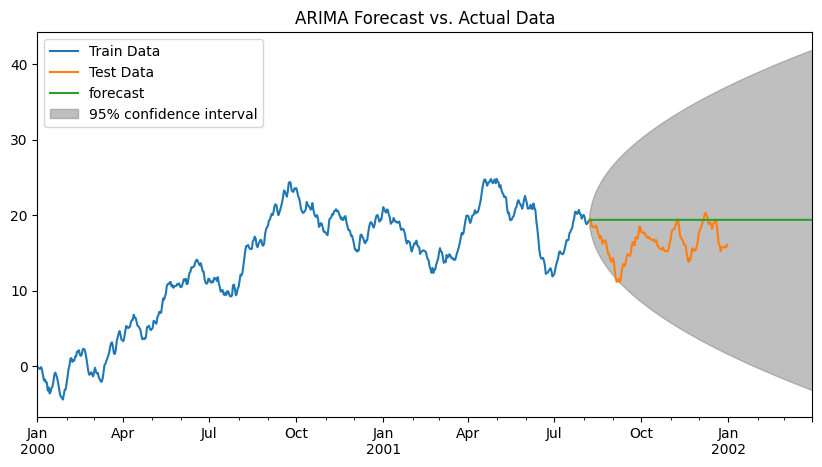

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

# rename the columns in the train and test sets for the legend labels
train.columns = ['Train Data']
test.columns = ['Test Data']

# plot the train and test data
train.plot(ax=ax)
test.plot(ax=ax)

# add 90 days after the test set ends for the forecast end date
forecast_end = test.index[-1] + pd.Timedelta(days=90)

# forecast for test set period and 90 days after
plot_predict(results, start=test.index[0], end=forecast_end, ax=ax)

# add the title and legend
plt.title("ARIMA Forecast vs. Actual Data")
plt.legend(loc='best')
plt.show()

In [24]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             Train Data   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -350.812
Date:                Fri, 14 Feb 2025   AIC                            705.625
Time:                        19:20:08   BIC                            714.361
Sample:                    01-01-2000   HQIC                           709.030
                         - 08-06-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.837      0.000       0.336       0.485
sigma2         0.1950      0.012     15.888      0.000       0.171       0.219
Ljung-Box (L1) (Q):                   0.15   Jarque-

## Assess the Model's Performance
- Calculate the Root Mean Squared Error
- Plot the ARIMA Forecast vs. Test Data
- Forecast 1000 days into the future
- Print the various ranges
- Perform the ADF test on the model's residuals
- Plot the model's residuals
- Plot the ACF and PACF of the model's residuals

In [25]:
# generate predictions for the test set
predictions = results.get_prediction(start=test.index[0], end=test.index[-1])

# extract the predicted values
y_pred = predictions.predicted_mean

# calculate root mean Squared Error
rmse = mean_squared_error(test, y_pred)**(0.5)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 3.5608158565268164


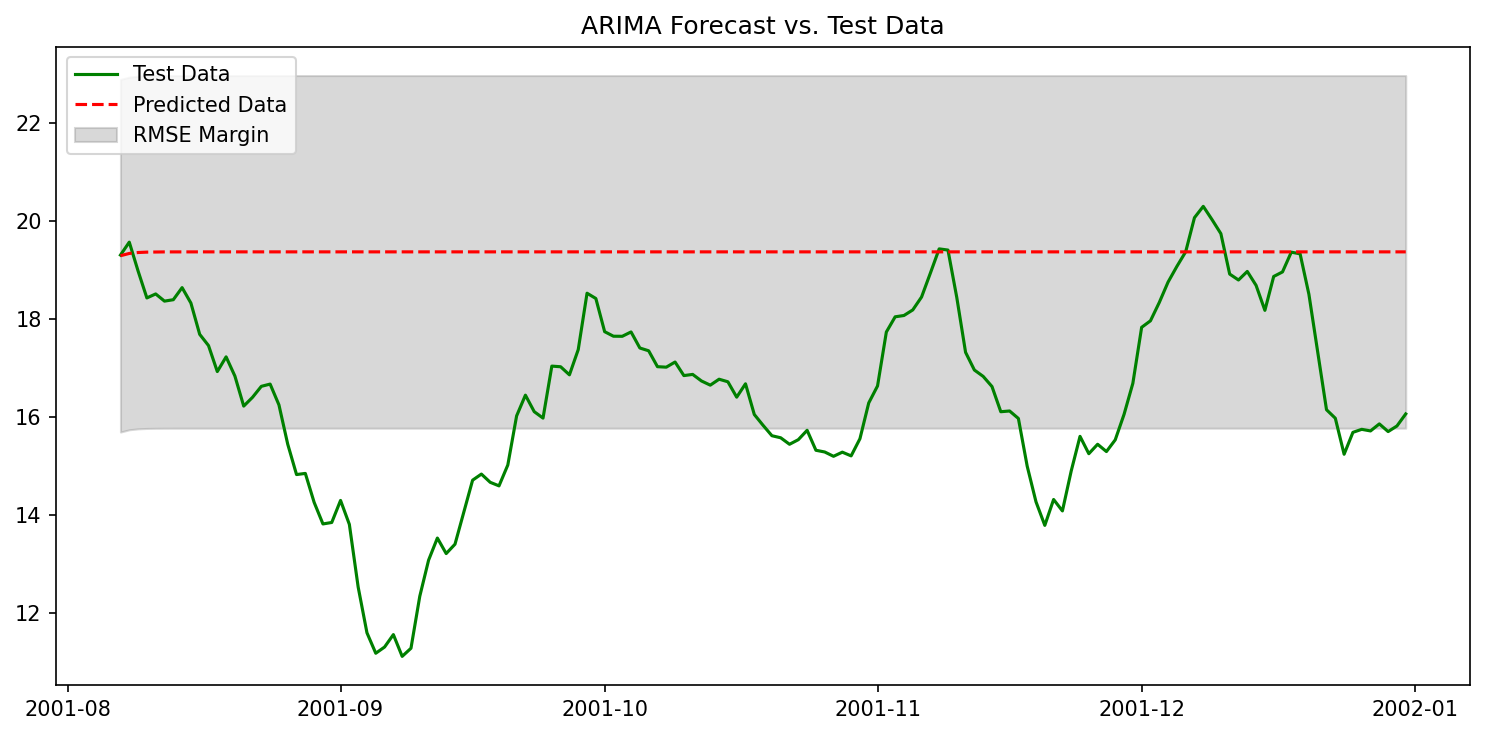

In [26]:
plt.figure(figsize=(10, 5), dpi=150)

# plot the test data and forecast
test_line, = plt.plot(test.index, test, label="Test Data", color="green")
pred_line, = plt.plot(test.index, y_pred, label="Predicted Data", color="red", linestyle="dashed")

# add # the shaded area for the margin of error (RMSE)
fill = plt.fill_between(test.index, y_pred - 3.6, y_pred + 3.6, color='gray', alpha=0.3)

# manually add the legend with handles
plt.legend([test_line, pred_line, fill], ["Test Data", "Predicted Data", "RMSE Margin"], loc="upper left")

# add the title and legend
plt.title("ARIMA Forecast vs. Test Data")
plt.tight_layout()
plt.show()

In [27]:
# extract and print the range of revenue values
rev_min, rev_max = medical_time_series['Revenue'].min(), medical_time_series['Revenue'].max()
print(f'Total Revenue Range: {rev_min:.4f} to {rev_max:.4f}')

# extract and print the range of test values
rev_min, rev_max = test['Test Data'].min(), test['Test Data'].max()
print(f'Test Data Range: {rev_min:.4f} to {rev_max:.4f}')

# extract and print the range of the predictions
pred_min, pred_max = y_pred.min(), y_pred.max()
print(f'Prediction Range: {pred_min:.4f} to {pred_max:.4f}')

# start the forecast one day after the last test date
forecast_start = test.index[-1] + pd.Timedelta(days=1)  

# generate future index for forecasting
future_index = pd.date_range(start=forecast_start, periods=1000, freq='D')

# forecast 1000 days into the future
far_future_projections = results.forecast(steps=1000)

rev_min, rev_max = min(far_future_projections), max(far_future_projections)
print(f'1000-day forecast Range: {rev_min:.4f} to {rev_max:.4f}')

Total Revenue Range: -4.4233 to 24.7922
Test Data Range: 11.1192 to 20.3071
Prediction Range: 19.2994 to 19.3783
1000-day forecast Range: 19.2994 to 19.3783


In [28]:
# print the first 5 predictions
y_pred.head()

2001-08-07    19.299360
2001-08-08    19.345870
2001-08-09    19.364967
2001-08-10    19.372809
2001-08-11    19.376029
Freq: D, Name: predicted_mean, dtype: float64

In [29]:
# store the model's residuals to model_residuals
model_residuals = results.resid

# perform the ADF test on the model's residuals
result = adfuller(model_residuals)

# the ADF statistic is low enough to reject non-stationarity.
print(F"The ADF statistc is {round(result[0], 2)} > {round(result[4]['5%'], 2)} (5%)")

# the p-value 0.0 < 0.05 so reject the null hypothesis 
# that the model's residuals are non-stationary
print("The p-value:", round(result[1], 2))
print("The lags used:", round(result[2], 2))
print("The number of observations used:", round(result[3], 2))

# round the critical values
rounded_critical_values = {key: round(value, 2) for key, value in result[4].items()}
print("Critical Values:", rounded_critical_values)

The ADF statistc is -14.46 > -2.87 (5%)
The p-value: 0.0
The lags used: 2
The number of observations used: 581
Critical Values: {'1%': -3.44, '5%': -2.87, '10%': -2.57}


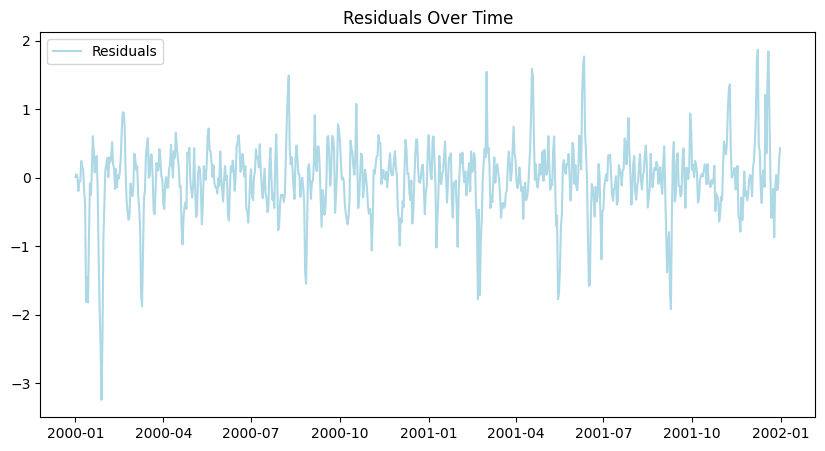

In [30]:
# plot of the residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Residuals", color='lightblue')
plt.title("Residuals Over Time")
plt.legend()
plt.show()

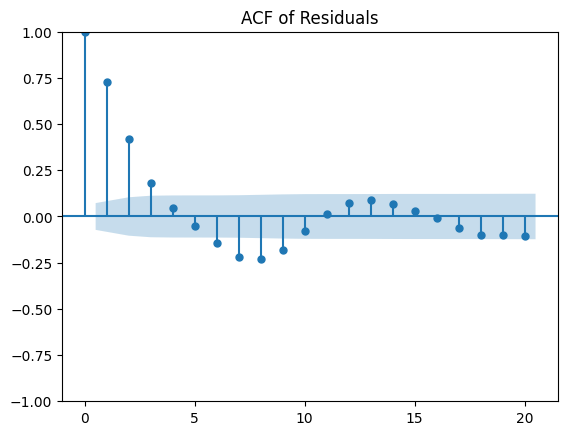

In [31]:
# ACF of Residuals
plot_acf(residuals, lags=20)
plt.title("ACF of Residuals")
plt.show()

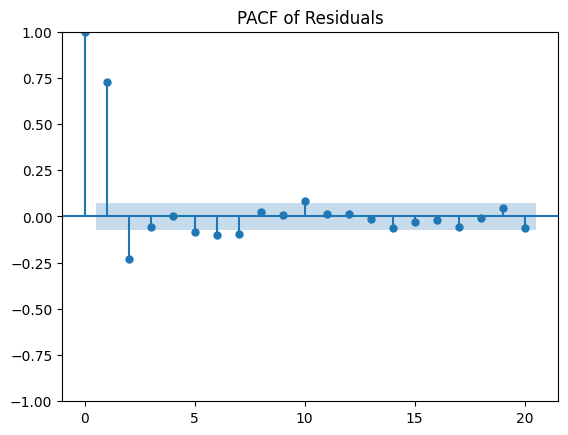

In [32]:
# PACF of Residuals
plot_pacf(residuals, lags=20)
plt.title("PACF of Residuals")
plt.show()

## Results

- No missing values or duplicates.
- Time series was not stationary:
    - Failed the ADF test (`p-value ~0.2 < 0.05`, ADF statistic > all critical values).
    - Fail to reject the null hypothesis that the time series is non-stationary.
    - Rolling mean and rolling standard deviation were not stable.
- Revenue appeared to follow a random drift with mean reversion.
- No seasonality detected:
    - Spectral density plot showed a gradual decrease without distinct peaks.
    - Seasonal-Trend decomposition (STL) confirmed long term increasing trend, no seasonality, and residuals appeared random.
- STL Residuals were stationary:
    - Passed ADF test (`p-value ~0.0 < 0.05`, ADF statistic < all critical values).
    - Reject the null hypothesis that the data is non-stationary.
- Autocorrelation analysis:
    - ACF: Gradual decrease, indicating no MA terms needed `(q = 0)`.
    - PACF: 1 term was highly significant; 2 terms showed some significance `(p = (2, 1))`.
- Stationarity achieved with 1 differencing step `(d = 1)`:
    - ADF test confirmed stationarity after first differencing (`p-value ~0.0 < 0.05`).
    - Reject the null hypothesis that the data is non-stationary.
- Model selection:
    - Compared ARIMA models: `(2,1,0)`, `(1,1,0)`, `(1,1,1)`, `(1,0,0)`.
    - Extra AR term in `(2,1,0)` had a high p-value (~0.4), not significant.
    - Extra MA term in `(1,1,1)` had a high p-value (~0.59), not significant.
    - Removing differencing in `(1,0,0)` resulted in substantially worse AIC and BIC scores.
    - Optimal model: `ARIMA(1,1,0)` (lowest AIC/BIC, significant parameters with near zero p-values).
- Model performance:
    - `RMSE ~3.6`, which is moderate considering the revenue range (~-4 to ~25), but it is not alarmingly high.
    - Model residuals passed the ADF test (`p-value ~0 < 0.05`, ADF statistic < all critical values).
    - Model residuals resemble white noise, so no remaining patterns.
    - Model residuals ACF/PACF confirm short-term dependencies only.
- Forecast values remained in a narrow range (~19.3 to ~19.8) throughout the entire forecast length.
- Expanding the forecast window to 1000 days showed no deviation from this range, suggesting the model assumes the  revenue will stabilize.
- Model may be have too low of a complexity or the time series follows a random walk with drift.

## Reccomendations

The time series analysis identified a long-term upward trend in revenue but no consistent patterns beyond that. The series appears to follow a random walk with drift, suggesting that its fluctuations are likely influenced by external factors. Therefore, future analyses should incorporate additional variables to better understand these influences.
The model's low RMSE of approximately 3.6 indicates a moderately low margin of error, making it reliable for short-term predictions. The forecast length should remain within the test data range of 147 days because the prediction interval was narrow in this range, suggesting that 95% of actual values should confidently fall within it. However, the model is not recommended for long-term projections because it assumes the series will plateau and stabilize, failing to account for any future variability.
Additionally, the narrow forecast range fails to capture the natural oscillations in revenue. This is likely due to the model's simplicity because it includes only one AR term and relies only on the previous value for its predictions. Alternatively, the time series may follow a random walk with drift, so long-term predictions are inherently difficult due to the increasing random and unstructured variability. Therefore, more flexible models should be explored to better capture the underlying structure of the data. Moreover, the model's effectiveness depends on the original revenue scale, and the standardization makes it difficult to interpret the significance of the error metric. The next steps should include investigating external revenue factors, incorporating additional features, destandardizing the data and RMSE for better interpretability, and exploring alternative time series models to improve the forecasting accuracy.


In [33]:
# export the cleaned dataset to a CSV file
#medical_time_series.to_csv('cleaned_data_task1.csv', index=True)